DeepLearningCourse vol.3
# chainerチュートリアル with MNIST

In [1]:
# 必要なモジュールのインポート

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## MNISTとは？

### MNISTとは､手書き数字画像のデータセットです。
![](https://www.tensorflow.org/versions/master/images/MNIST.png)
このような0〜9の手書き数字の画像（28px × 28px）が計7万枚収録されています。

In [2]:
# MNISTのデータセットを読み込む
train, test = chainer.datasets.get_mnist()

In [3]:
# 画像を表示する関数
def draw_digit(data):
    """数値の行列データを画像表示"""
    size = 28
    plt.figure(figsize=(3, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

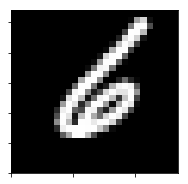

In [4]:
# データセットの画像を見てみましょう｡
# 一つ目の[]の中の数字を変えて､いろんな数字の画像が含まれているのを確認しましょう
sample_data = np.array(train[999][0])
draw_digit(sample_data)

## MNISTデータセットの構造
MNISTのデータセットは､,このように手書き数字の画像と､答えとなる数字データがセットで並んでいます｡  
1つ目の [] が横の番号を､2つ目の [] が縦の番号を表しています｡
![](https://www.fastpic.jp/images.php?file=3409487222.png)

In [5]:
sample_data

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## もっと見やすくすると､こんな感じです｡
各位置の黒さと､数字の大きさが対応していることがわかります｡
![](https://www.tensorflow.org/versions/master/images/MNIST-Matrix.png)

参考URL：http://tensorflow.classcat.com/2016/03/09/tensorflow-cc-mnist-for-ml-beginners/

### モデルの定義
ここでは、シンプルな三層パーセプトロンを定義します。これは全結合層のみからなるネットワークです。中間層のユニット数は適当に100とし、出力は10クラスなので10とします。ここで用いるMNISTデータセットは10種のラベルを持つためです。では、モデルを定義するために必要な`Link`, `Function`, そして`Chain`について、簡単にここで説明を行います。

### LinkとFunction

- Chainerでは、ニューラルネットワークの各層を、`Link`と`Function`に区別します。
- **`Link`は、パラメータを持つ関数です。**
- **`Function`は、パラメータを持たない関数です。**
- これらを組み合わせてモデルを記述します。
- パラメータを持つ層は、`chainer.links`モジュール以下にたくさん用意されています。
- パラメータを持たない層は、`chainer.functions`モジュール以下にたくさん用意されています。
- これらを簡単に使うために、
    ```
    import chainer.links as L
    import chainer.functions as F
    ```
    と別名を与えて、`L.Convolution2D(...)`や`F.relu(...)`のように用いる慣習があります。

### Chain

- Chainは、パラメータを持つ層＝**`Link`をまとめておくためのクラス**です。
- パラメータを持つということは、基本的にモデルの学習の際にそれらを更新していく必要があるということです（例外はあります）。
- そこで、学習中に`Optimizer`が更新すべき全てのパラメータを簡単に取得できるように、`Chain`で一箇所にまとめておきます。

### Chainを継承して定義されるモデル

- モデルは`Chain`クラスを継承したクラスとして定義されることが多いです。
- その場合、モデルを表すクラスのコンストラクタで、親クラスのコンストラクタにキーワード引数の形で登録したい層の名前と、オブジェクトを渡しておくと、自動的に`Optimizer`から見つけられる形で保持しておいてくれます。
- これは、別の場所で`add_link`メソッドを使っても行うことができます。 
- また、関数呼び出しのようにしてモデルに`()`アクセサでデータを渡せるように、`__call__`メソッドを定義して、その中にforward処理を記述すると便利です。

In [6]:
# ニューラルネットのモデルを定義
# 層が5つ以上になってくると､Deep Learningと呼ばれるようになります｡

class MLP(chainer.Chain):

    def __init__(self):
        """ ネットワークの構造を定義 """
        super(MLP, self).__init__(
            l1=L.Linear(784, 900),   # 入力784ユニット、 出力900ユニット
            l2=L.Linear(900, 1200),  # 入力900ユニット、 出力1200ユニッ
            l3=L.Linear(1200, 800),  # 入力1200ユニット、出力800ユニット
            l4=L.Linear(800, 500),   # 入力800ユニット､  出力500ユニット
            l5=L.Linear(500, 10),    # 入力500ユニット､  出力10ユニット
        )

    def __call__(self, x):
        """ 計算の規則を定義 """
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        return self.l5(h4)

## 定義されたモデルを図にすると以下のようになります。

人間の脳のニューロンの繋がりを模しているので､ニューラルネットワークと呼ばれます｡
各パーセプトロンで計算した数値が､次々に右側の層へ受け渡されていきます｡

これは､人間の脳で行われている､電気信号の受け渡しを表現しています｡

手書き数字のデータ（28px × 28px）を変換すると､784次元のベクトルになります｡
インプットの数値の個数は784ユニットになります。

中間の層の数は､大体で決めています｡それなりに大きな数であれば､ある程度なんでも大丈夫です｡

最後の層では、0〜9の数字である確率を出力するため10個のユニットになります。
![](https://qiita-image-store.s3.amazonaws.com/0/50670/155b9533-4b47-0748-226c-1e3082930ed9.png)

参考URL：http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412

In [7]:
# ミニバッチのサイズを指定
batchsize = 100

# 学習の繰り返し回数（epoch）を指定
epoch = 20

# 訓練のためのニューラルネットワークをセットアップする
model = L.Classifier(MLP())

#### Iteratorの作成
データセットから決まった数のデータを取り出し、それらを束ねてミニバッチを作成して返してくれるIteratorを作成しましょう。これをこの後の学習ループの中で使用していきます。

 Chainerがいくつか用意しているIteratorの一種である`SerialIterator`は、データセットの中のデータを順番に取り出してくる最もシンプルなIteratorです。
 
引数にデータセットオブジェクトと、バッチサイズを取ります。
また、このとき渡したデータセットから、何周も何周もデータを繰り返し読み出す必要がある場合は`repeat`引数を`True`とし、1周が終わったらそれ以上データを取り出したくない場合はこれを`False`とします。デフォルトでは、`True`になっています。
`shuffle`引数に`True`を渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。

In [8]:
# データセットをイテレータの形式に変換する
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

### 最適化手法の選択
Chainerは多くの最適化手法を提供しています。`chainer.optimizers`モジュール以下にそれらはあります。ここでは最もシンプルな勾配降下法の手法である`optimizers.SGD`を用います。Optimizerのオブジェクトには、`setup`メソッドを使ってモデル（`Chain`オブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。

In [9]:
# 最適化の方法を定義
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

### Updater
![](https://s3.amazonaws.com/ai-standard/pic-d3-5.png)

Updaterは中にIteratorとOptimizerを持っています。Iteratorからはデータセットを参照することができ、Optimizerはモデルの参照を持っています。

Updater内では以下の処理が行われます。
- データセットからデータをIteratorで取り出す
- モデルに渡してlossを計算する
- Optimizerを使って、モデルのパラメータの更新をする

In [10]:
# updaterにiteratorとoptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer)

### trainer
Trainerのオブジェクトを作成する際に必須となるのは、先程作成したUpdaterオブジェクトだけですが、二番目の引数stop_triggerに学習をどのタイミングで終了するかを表す(長さ, 単位)という形のタプルを与えると、指定したタイミングで学習を自動的に終了することができます。長さには任意の整数、単位には'epoch'か'iteration'のいずれかの文字列を指定できます。stop_triggerを指定しない場合、学習は自動的には止まりません。

In [ ]:
# trainerにupdaterを渡す
trainer = training.Trainer(updater, (epoch, 'epoch'))

### extention の設定
#### `Evaluator`
> 評価用のデータセットの`Iterator`と、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。

#### `LogReport`
>`epoch`や`iteration`ごとの`loss`, `accuracy`などを自動的に集計し、`Trainer`の`out`引数で指定した出力ディレクトリに`log`というファイル名で保存します。

#### `PrintReport`
>`Reporter`によって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。

#### `PlotReport`
> 引数のリストで指定された値の変遷を`matplotlib`ライブラリを使ってグラフに描画し、出力ディレクトリに`file_name`引数で指定されたファイル名で画像として保存します。

In [11]:
# epochごとに学習後の精度を評価する
trainer.extend(extensions.Evaluator(test_iter, model))

# epochごとにlogを出力する
trainer.extend(extensions.LogReport())

# logに出力する情報を指定する
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                                       'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))

# 構成したtrainerをもとに､学習を実行する
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.20878     0.104125              0.935767       0.9683                    70.8486       
2           0.0883471   0.099857              0.973783       0.969                     161.415       
3           0.063475    0.0782755             0.981533       0.9784                    266.3         
4           0.0498794   0.0941134             0.985333       0.9742                    348.813       
5           0.0429098   0.0801073             0.986983       0.9797                    420.415       
6           0.0332529   0.111198              0.989983       0.9735                    497.006       
7           0.0292616   0.0891346             0.991883       0.9777                    567.656       
8           0.0311657   0.0884774             0.99135        0.9817                    649.867       
9           0.0271153   0.0796205             0.9923         0.9819                 

#### lossのグラフ
![](https://s3.amazonaws.com/ai-standard/pic-d3-6.png)
#### 精度のグラフ
![](https://s3.amazonaws.com/ai-standard/pic-d3-7.png)

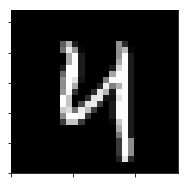

In [12]:
# 学習済みモデルを使用して予測

# 予測したいデータのindexを入力
# testから出力するので､ 0 <= index <= 9999 の範囲から選択

index = 789

# 予測したい画像を表示
pred = np.array(test[index][0]).reshape(-1, 1, 28, 28)
draw_digit(pred)

In [13]:
# ニューラルネットで書いてある数字を予測
# このあたりはあまり重要ではないので､コピペで大丈夫です｡
mnist_test = model.predictor(pred)
pre_num = int(np.argmax(mnist_test.data, axis=1))

# 予測結果を出力
print("予測:" + str(pre_num))

# 正解したのか､間違えたのかを出力
if pre_num == test[index][1]:
    print('正解しました！')
else:
    print('間違えました...')

予測:4
正解しました！
